In [164]:
import tensorflow_datasets as tfds

In [165]:
import numpy as np
import pandas as pd
from os import sep
from scipy import sparse;
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import string
import re
from nltk.stem.porter import PorterStemmer

In [166]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [167]:
from nltk.corpus import wordnet

In [168]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [169]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [170]:
df = pd.read_csv('./drive/MyDrive/imdb/ml_detail.csv', sep=',', encoding='latin-1')

In [171]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
df["content"] = df["content"].apply(lambda text: remove_html(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81


In [172]:
df["text_lower"] = df["content"].str.lower()
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ..."
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...


In [173]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace_contraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text
df["text_contraction_extract"] = df["text_lower"].apply(lambda text: replace_contraction(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ..."
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [174]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
df["text_wo_punct"] = df["text_contraction_extract"].apply(lambda text: remove_punctuation(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [175]:
!pip install pyspellchecker

In [176]:

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [177]:
#df["text_correct_spellings"] = df["text_wo_punct"].apply(lambda text: correct_spellings(text))

In [178]:
def replace(word, pos=None):
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None
def replaceNegations(text):
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words
def negation_preprocess(text):
  res = " ".join(replaceNegations(text.split(" ")))
  return res
df["text_negation_preprocess"] = df["text_wo_punct"].apply(lambda text: negation_preprocess(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...


In [179]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(content):
  word_tokens = word_tokenize(content)
 
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
  filtered_sentence = []
  
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return ' '.join(filtered_sentence)
df["text_wo_stop"] = df["text_negation_preprocess"].apply(lambda text: remove_stopwords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stop
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,always kind perverse curiosity animated movie ...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox moronic release film theaters...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind movie reminds words cute sweet quirky oug...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,moving animã© film studio ghibli good anything...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based autobiographical tale writer toby young ...


In [180]:
from collections import Counter
cnt = Counter()
for text in df['text_wo_stop'].values:
  for word in text.split():
    cnt[word] += 1
cnt.most_common(10)

[('film', 123491),
 ('movie', 106573),
 ('one', 97382),
 ('like', 77362),
 ('good', 62194),
 ('story', 53245),
 ('would', 51747),
 ('really', 51139),
 ('also', 47790),
 ('well', 45425)]

In [181]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(2)])
FREQWORDS.add("movie")
FREQWORDS.add("story")
FREQWORDS.add("imdb")

In [182]:
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stop,text_wo_stopfreq
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,always kind perverse curiosity animated movie ...,always kind perverse curiosity animated starri...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox moronic release film theaters...,20th century fox moronic release theaters scif...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind movie reminds words cute sweet quirky oug...,kind reminds words cute sweet quirky ought cri...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,moving animã© film studio ghibli good anything...,moving animã© studio ghibli good anything eith...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...


In [183]:
len(cnt)

362448

In [184]:
n_rare_words = 10000
RAREWORDS = set()
for (w, wc) in cnt.most_common():
  if wc == 1:
    RAREWORDS.add(w)
RAREWORDS

{'frenching',
 'exparamours',
 'manipulatedanyways',
 'woodswhat',
 'spitefulness',
 'forgotand',
 'disgruntledwe',
 'momentsrachel',
 'creepfestthis',
 'nameno',
 'manureto',
 'headplanet',
 'clubbingthe',
 'lukeof',
 'shotsit',
 'modiocre',
 'longhis',
 'townnone',
 'showactingwise',
 'scattegories',
 'elliptic',
 'gearjeff',
 'herevin',
 'disappointedbesides',
 'bettergood',
 'anymoremaybe',
 'rhymesoundtracks',
 'peeand',
 'pointlessthat',
 'landayoade',
 'cartelsdenzel',
 'privacyit',
 'newlycommissioned',
 'helmthis',
 'mulderthe',
 'irregularitiesthe',
 'redstuff',
 'nomenklatura',
 'nonattributes',
 'sharpsuited',
 'castingdie',
 'antzthis',
 'cheesinessthe',
 'santonigets',
 'semiflashy',
 'uhd',
 'behindafterward',
 'megacomputers',
 'betincluding',
 'shw',
 'hyperspacial',
 'abortionjimmy',
 'personalitiesalthough',
 'hijinkswatching',
 'berlitz',
 'promisingas',
 'arrestsfinallyseason',
 'characterplenty',
 '1994well',
 'limitswith',
 '180â°turn',
 'sullivankristen',
 'bret

In [185]:
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stop,text_wo_stopfreq,text_wo_stopfreqrare
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,always kind perverse curiosity animated movie ...,always kind perverse curiosity animated starri...,always kind perverse curiosity animated starri...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox moronic release film theaters...,20th century fox moronic release theaters scif...,20th century fox moronic release theaters scif...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind movie reminds words cute sweet quirky oug...,kind reminds words cute sweet quirky ought cri...,kind reminds words cute sweet quirky ought cri...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,moving animã© film studio ghibli good anything...,moving animã© studio ghibli good anything eith...,moving animã© studio ghibli good anything eith...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...


In [186]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [187]:
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stop,text_wo_stopfreq,text_wo_stopfreqrare,text_lemmatized
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,always kind perverse curiosity animated movie ...,always kind perverse curiosity animated starri...,always kind perverse curiosity animated starri...,always kind perverse curiosity animate star ro...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox moronic release film theaters...,20th century fox moronic release theaters scif...,20th century fox moronic release theaters scif...,20th century fox moronic release theater scifi...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind movie reminds words cute sweet quirky oug...,kind reminds words cute sweet quirky ought cri...,kind reminds words cute sweet quirky ought cri...,kind remind word cute sweet quirky ought criti...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,moving animã© film studio ghibli good anything...,moving animã© studio ghibli good anything eith...,moving animã© studio ghibli good anything eith...,move animã© studio ghibli good anything either...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...,base autobiographical tale writer toby young f...


In [188]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [189]:
df["text_no_url"] = df['text_lemmatized'].apply(lambda text: remove_urls(text))

In [190]:
def remove_numbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text
df["text_no_number"] = df['text_no_url'].apply(lambda text: remove_numbers(text))

In [191]:
df["review"] = df["text_no_number"].apply(lambda x: str(x).lower())

In [192]:
df.to_csv('./drive/MyDrive/imdb/ml_detail_text_preprocessing.csv', encoding='latin-1', sep=',', index=False)

In [193]:
df = pd.read_csv('./drive/MyDrive/imdb/ml_detail_text_preprocessing.csv', encoding='latin-1', sep=',')

In [194]:
df.head()

,movie id,user id,rating,content,date,movie index,user index,text_lower,text_contraction_extract,text_wo_punct,text_negation_preprocess,text_wo_stop,text_wo_stopfreq,text_wo_stopfreqrare,text_lemmatized,text_no_url,text_no_number,review
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81,i've always had kind of a perverse curiosity a...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,i have always had kind of a perverse curiosity...,always kind perverse curiosity animated movie ...,always kind perverse curiosity animated starri...,always kind perverse curiosity animated starri...,always kind perverse curiosity animate star ro...,always kind perverse curiosity animate star ro...,always kind perverse curiosity animate star ro...,always kind perverse curiosity animate star ro...
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox was moronic not to release th...,20th century fox moronic release film theaters...,20th century fox moronic release theaters scif...,20th century fox moronic release theaters scif...,20th century fox moronic release theater scifi...,20th century fox moronic release theater scifi...,th century fox moronic release theater scifi a...,th century fox moronic release theater scifi a...
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81,it's the kind of movie that reminds me that th...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,it is the kind of movie that reminds me that t...,kind movie reminds words cute sweet quirky oug...,kind reminds words cute sweet quirky ought cri...,kind reminds words cute sweet quirky ought cri...,kind remind word cute sweet quirky ought criti...,kind remind word cute sweet quirky ought criti...,kind remind word cute sweet quirky ought criti...,kind remind word cute sweet quirky ought criti...
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81,"a very moving animã© film from studio ghibli, ...","a very moving animã© film from studio ghibli, ...",a very moving animã© film from studio ghibli a...,a very moving animã© film from studio ghibli a...,moving animã© film studio ghibli good anything...,moving animã© studio ghibli good anything eith...,moving animã© studio ghibli good anything eith...,move animã© studio ghibli good anything either...,move animã© studio ghibli good anything either...,move animã© studio ghibli good anything either...,move animã© studio ghibli good anything either...
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based on the autobiographical tale of writer t...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...,based autobiographical tale writer toby young ...,base autobiographical tale writer toby young f...,base autobiographical tale writer toby young f...,base autobiographical tale writer toby young f...,base autobiographical tale writer toby young f...


In [210]:
df.dropna(subset=['review'], inplace=True)

In [211]:
contents = df["review"].tolist()

In [212]:
train_contents = contents[:80000]
test_contents = contents[80000:]

In [213]:
val_contents = train_contents[70000:]
train_contents = train_contents[:70000]

In [214]:
labels = []

In [215]:
import seaborn as sns

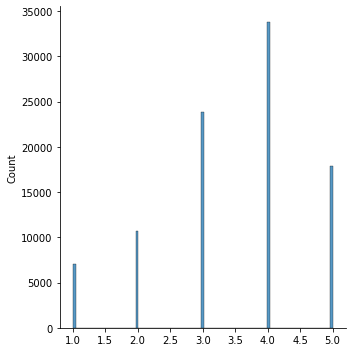

In [216]:
sns.displot(df['rating'].tolist(),)

In [217]:
for rating in df['rating']:
  if (int(rating) <= 3):
    labels.append(0)
  else :
    labels.append(1)
 

In [218]:
train_labels = labels[:80000]
test_labels = labels[80000:]


In [219]:
val_labels = train_labels[70000:]
train_labels = train_labels[:70000]

In [220]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [221]:
vocab_size = 10000
embedding_dim = 64
max_length = 500

In [222]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [223]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")

In [224]:
tokenizer.fit_on_texts(train_contents)

In [225]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'one': 2,
 'like': 3,
 'make': 4,
 'get': 5,
 'good': 6,
 'character': 7,
 'see': 8,
 'well': 9,
 'time': 10,
 'go': 11,
 'would': 12,
 'really': 13,
 'also': 14,
 'show': 15,
 'watch': 16,
 'take': 17,
 'even': 18,
 'much': 19,
 'play': 20,
 'first': 21,
 'scene': 22,
 'great': 23,
 'way': 24,
 'come': 25,
 'end': 26,
 'look': 27,
 'give': 28,
 'find': 29,
 'two': 30,
 'thing': 31,
 'say': 32,
 'think': 33,
 'work': 34,
 'could': 35,
 'bad': 36,
 'little': 37,
 'love': 38,
 'know': 39,
 'people': 40,
 'year': 41,
 'still': 42,
 'cast': 43,
 'seem': 44,
 'life': 45,
 'film': 46,
 'many': 47,
 'best': 48,
 'series': 49,
 'new': 50,
 'lot': 51,
 'never': 52,
 'action': 53,
 'back': 54,
 'want': 55,
 'try': 56,
 'man': 57,
 'star': 58,
 'movie': 59,
 'part': 60,
 'young': 61,
 'though': 62,
 'plot': 63,
 'act': 64,
 'role': 65,
 'big': 66,
 'quite': 67,
 'pretty': 68,
 'bit': 69,
 'comedy': 70,
 'actor': 71,
 'another': 72,
 'turn': 73,
 'something': 74,
 'old': 75,
 'start'

In [226]:
train_sequences = tokenizer.texts_to_sequences(train_contents)

In [227]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')

In [228]:
test_sequences = tokenizer.texts_to_sequences(test_contents)
val_sequences = tokenizer.texts_to_sequences(val_contents)

In [229]:
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_val_sequences = pad_sequences(val_sequences, maxlen=max_length, truncating='post', padding='post')

In [230]:
padded_val_sequences

array([[   1, 1248,   51, ...,    0,    0,    0],
       [ 560,  234,   70, ...,    0,    0,    0],
       [   2, 9970, 1260, ...,    0,    0,    0],
       ...,
       [  58,  193, 2171, ...,    0,    0,    0],
       [  49, 1192,  678, ...,    0,    0,    0],
       [  38, 1317, 1142, ...,    0,    0,    0]], dtype=int32)

In [231]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [232]:
model = Sequential()

In [233]:
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

In [234]:
model.add(Flatten())

In [235]:
model.add(Dropout(0.05))

In [236]:
model.add(Dense(64, activation='relu'))

In [237]:
model.add(Dense(2, activation='softmax'))

In [238]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [239]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 64)           640000    
                                                                 
 flatten_3 (Flatten)         (None, 32000)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32000)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2048064   
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,688,194
Trainable params: 2,688,194
Non-trainable params: 0
_________________________________________________________________


In [240]:
from keras.utils import np_utils
train_l = np_utils.to_categorical(train_labels,2)
test_l = np_utils.to_categorical(test_labels, 2)
val_l = np_utils.to_categorical(val_labels, 2)

In [241]:
train_l

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [242]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [243]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5)

In [244]:
model.fit(padded_train_sequences, train_l, epochs=100, batch_size=128, validation_data=(padded_val_sequences, val_l), callbacks=[callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


547/547 [==============================] - 77s 141ms/step - loss: 0.5776 - acc: 0.6725 - val_loss: 0.4878 - val_acc: 0.7710
Epoch 2/100
547/547 [==============================] - 76s 140ms/step - loss: 0.3581 - acc: 0.8451 - val_loss: 0.5303 - val_acc: 0.7607
Epoch 3/100
547/547 [==============================] - 77s 141ms/step - loss: 0.1115 - acc: 0.9610 - val_loss: 0.7462 - val_acc: 0.7429
Epoch 4/100
547/547 [==============================] - 77s 141ms/step - loss: 0.0243 - acc: 0.9927 - val_loss: 1.1191 - val_acc: 0.7311
Epoch 5/100
547/547 [==============================] - 77s 141ms/step - loss: 0.0083 - acc: 0.9979 - val_loss: 1.3614 - val_acc: 0.7386
Epoch 6/100
547/547 [==============================] - 76s 139ms/step - loss: 0.0041 - acc: 0.9991 - val_loss: 1.5171 - val_acc: 0.7313


In [245]:
test_predicted = model.predict(padded_test_sequences)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [246]:
predicted_labels = []

In [247]:

for result_one_hot_predicted in test_predicted:
  rating_predicted = np.argmax(result_one_hot_predicted)
  predicted_labels.append(rating_predicted)


In [248]:
predicted_labels

[1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,


In [249]:
score = model.evaluate(padded_test_sequences, test_l,verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [250]:
print(score)

[1.2949855327606201, 0.7493770122528076]


In [251]:
embedding_layer = model.layers[0]

In [252]:
weights = embedding_layer.get_weights()[0]

In [253]:
import io

out_v = io.open('./drive/MyDrive/imdb/imdb_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./drive/MyDrive/imdb/imdb_meta.tsv', 'w', encoding='utf-8')

for idx in range(1, vocab_size):
  word = tokenizer.index_word[idx]
  vector = weights[idx]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(vi) for vi in vector]) + "\n")

out_m.close()
out_v.close()

In [254]:
model_json = model.to_json()

In [255]:
with open("./drive/MyDrive/imdb/imdb_model.json", "w") as json_file:
  json_file.write(model_json)

In [256]:
model.save_weights("./drive/MyDrive/imdb/model.h5")

In [257]:
json_file = open('./drive/MyDrive/imdb/imdb_model.json', 'r')

In [258]:
loaded_model_json = json_file.read()

In [259]:
json_file.close()

In [260]:
from keras.models import model_from_json
loaded_model = model_from_json(loaded_model_json)

In [261]:
loaded_model.load_weights('./drive/MyDrive/imdb/model.h5')

In [262]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [263]:
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 64)           640000    
                                                                 
 flatten_3 (Flatten)         (None, 32000)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32000)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2048064   
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,688,194
Trainable params: 2,688,194
Non-trainable params: 0
_________________________________________________________________
